# Wind Data Site Picker

This script uses a shp file and returns a dataframe storing the point locations of up to 3 wind turbine data stations by county. This maximum number can be adjusted for a finer analysis. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from io import StringIO
import sys
import time
import csv
import logging
import os
from os import path
from shapely import wkb, wkt
from shapely.geometry import Point, shape, Polygon, MultiPolygon
import traceback
from pywtk.site_lookup import get_3tiersites_from_wkt
import fiona
import random
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch


In [9]:
# Read in shape file 
shape = fiona.open("/Users/julianschmitt/Documents/Schoolwork/Junior Fall/EPS 168/project/tl_2016_us_county.shp")

In [92]:
# sample object with indexing shown
first= shape.next()
sample_county = Polygon(first['geometry']['coordinates'][0])
sample_county.area

<ipython-input-92-50b19b633dcc>:2: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  first= shape.next()


0.08669218443799927

In [5]:
# Read in the corn data set
corn = pd.read_csv("~/Documents/Schoolwork/Junior Fall/EPS 168/project/data/data_yield/Maize_1999_2019_NASS.csv")

In [6]:
# Match up the county and state values
corn_ansi = corn[['County ANSI', 'State ANSI']].dropna()
corn_county = map(str, map(int, corn_ansi['County ANSI'].values))
corn_state = map(str, map(int, corn_ansi['State ANSI'].values))
corn_sc = [" ".join(pair) for pair in zip(corn_state, corn_county)]

In [7]:
len(set(corn_sc))

2305

In [9]:
# Get all the counties and states out
state = [poly['properties']["STATEFP"] for poly in shape.values()]
county = [poly['properties']["COUNTYFP"] for poly in shape.values()]
state_county = [" ".join(pair) for pair in zip(state, county)]

In [10]:
len(set(state_county))

3233

In [94]:
poly = Polygon(first['geometry']['coordinates'][0])
print(len(str(poly))) # we see that each county has large resolution 

21770


## New direction/ breakthrough! 
We go through the shp file and do a site query for each county in the US. The plan is now to index and get needed counties afterwards. We create a dataframe with all of the counties in the shape file (some didn't work --potentially corrupted?) and save it. Work will continue elsewhere.



In [71]:
# store the following parameters in our dataframe. 
columns = ['NAME', 'STATE', 'STATEFP', 'COUNTYFP', 'NAMELSAD', 'POINT', 'SITE']

wind_stations = []
x = 0
for index, county in enumerate(shape):
    try:
        # get shape and request sites 
        poly = Polygon(county['geometry']['coordinates'][0])
        sites = get_3tiersites_from_wkt(f"{poly}")
        num_sites = min(3, len(sites)) # we should randomize the selection process for counties with >3 stations 
        rand_sites = random.sample(range(len(sites)), num_sites)
        sites_used = sites.iloc[rand_sites,:] # just use the first 3 sites
        # Get background data
        statefp, countyfp, name, namelsad = county['properties']['STATEFP'], county['properties']['COUNTYFP'], county['properties']['NAME'], county['properties']['NAMELSAD']
        for index, row in sites_used.iterrows():
            # Get station data
            point, site, state = row['point'], row['gid'], row['state'] # point will be used for data call later
            wind_stations.append({'NAME': name, 'STATE': state, 'STATEFP': statefp, 'COUNTYFP': countyfp, 
                       'NAMELSAD': namelsad, 'POINT': point, 'SITE': site})
    except:
        try:
            poly = Polygon(first['geometry']['coordinates'][0])
            name = poly['properties']['NAME']
            print(f"County {name} has no wind sites")
        except:
            print("Polygon Object failure") # has trouble reading the shape file for some reason.... maybe state level objects?
    
df = pd.DataFrame(wind_stations)
df

Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Obj

,NAME,STATE,STATEFP,COUNTYFP,NAMELSAD,POINT,SITE
0,Cuming,Nebraska,31,039,Cuming County,POINT (-96.985748 41.851967),66913
1,Wahkiakum,Washington,53,069,Wahkiakum County,POINT (-123.463028 46.366371),125299
2,De Baca,New Mexico,35,011,De Baca County,POINT (-104.26712 34.540672),16227
3,De Baca,New Mexico,35,011,De Baca County,POINT (-104.245026 34.542561),16228
4,De Baca,New Mexico,35,011,De Baca County,POINT (-104.222931 34.544441),16229
...,...,...,...,...,...,...,...
6429,Madison,Mississippi,28,089,Madison County,POINT (-90.192719 32.451344),10690
6430,Howard,Texas,48,227,Howard County,POINT (-101.283356 32.099888),9799
6431,Howard,Texas,48,227,Howard County,POINT (-101.420258 32.201256),10096
6432,Howard,Texas,48,227,Howard County,POINT (-101.398865 32.202473),10097


In [5]:
df.to_csv("US_wind_locations_3.csv") # save file to csv

In [4]:
columns = ['NAME', 'STATE', 'STATEFP', 'COUNTYFP', 'NAMELSAD', 'POINT', 'SITE']

wind_stations = []
x = 0
for index, county in enumerate(shape):
    try:
        # get shape and request sites 
        poly = Polygon(county['geometry']['coordinates'][0])
        sites = get_3tiersites_from_wkt(f"{poly}")
        num_sites = min(3, len(sites)) # we should randomize the selection process for counties with >3 stations 
        rand_sites = random.sample(range(len(sites)), num_sites)
        sites_used = sites.iloc[rand_sites,:] # just use the first 3 sites
        # Get background data
        statefp, countyfp, name, namelsad = county['properties']['STATEFP'], county['properties']['COUNTYFP'], county['properties']['NAME'], county['properties']['NAMELSAD']
        for index, row in sites_used.iterrows():
            # Get station data
            point, site, state = row['point'], row['gid'], row['state'] # point will be used for data call later
            wind_stations.append({'NAME': name, 'STATE': state, 'STATEFP': statefp, 'COUNTYFP': countyfp, 
                       'NAMELSAD': namelsad, 'POINT': point, 'SITE': site})
    except:
        try:
            poly = Polygon(first['geometry']['coordinates'][0])
            name = poly['properties']['NAME']
            print(f"County {name} has no wind sites")
        except:
            print("Polygon Object failure") # has trouble reading the shape file for some reason.... maybe state level objects?
df = pd.DataFrame(wind_stations)
df

Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Object failure
Polygon Obj

,NAME,STATE,STATEFP,COUNTYFP,NAMELSAD,POINT,SITE
0,Cuming,Nebraska,31,039,Cuming County,POINT (-96.985748 41.851967),66913
1,Wahkiakum,Washington,53,069,Wahkiakum County,POINT (-123.463028 46.366371),125299
2,De Baca,New Mexico,35,011,De Baca County,POINT (-104.088074 34.537392),16142
3,De Baca,New Mexico,35,011,De Baca County,POINT (-104.13678 34.57011),16316
4,De Baca,New Mexico,35,011,De Baca County,POINT (-104.15712 34.733997),17317
...,...,...,...,...,...,...,...
6429,Madison,Mississippi,28,089,Madison County,POINT (-90.192719 32.451344),10690
6430,Howard,Texas,48,227,Howard County,POINT (-101.463074 32.198784),10094
6431,Howard,Texas,48,227,Howard County,POINT (-101.393097 32.130051),9889
6432,Howard,Texas,48,227,Howard County,POINT (-101.418823 32.18314),10047


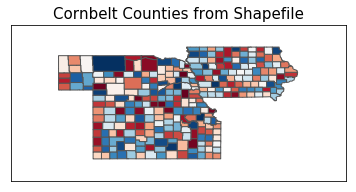

In [8]:
# We can extract the London Borough boundaries by filtering on the AREA_CODE key
mp = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open("/Users/julianschmitt/Documents/Schoolwork/Junior Fall/EPS 168/project/tl_2016_us_county.shp")
     if ((pol['properties']['STATEFP']=='20') or (pol['properties']['STATEFP']=='19') or (pol['properties']['STATEFP']=='31')) ])##.isin(['31','19','20'])

# We can now do GIS-ish operations on each borough polygon!
# we could randomize this by dumping the polygons into a list and shuffling it
# or we could define a random colour using fc=np.random.rand(3,)
# available colour maps are here: http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps
cm = plt.get_cmap('RdBu')

num_colours = len(mp)
 
fig = plt.figure()
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = mp.bounds
w, h = maxx - minx, maxy - miny
ax.set_xlim(minx - 0.2 * w, maxx + 0.2 * w)
ax.set_ylim(miny - 0.2 * h, maxy + 0.2 * h)
ax.set_aspect(1)

patches = []
for idx, p in enumerate(mp):
    colour = cm(1. * idx / num_colours)
    patches.append(PolygonPatch(p, fc=colour, ec='#555555', alpha=1., zorder=1))
ax.add_collection(PatchCollection(patches, match_original=True))
ax.set_xticks([])
ax.set_yticks([])
plt.title("Cornbelt Counties from Shapefile", fontsize=15)
plt.savefig('shapely.png', alpha=True, dpi=300)
plt.show()


In [23]:
[print(pol['properties']['ISO']) for pol in fiona.open("/Users/julianschmitt/Documents/Schoolwork/Junior Fall/EPS 168/project/tl_2016_us_county.shp")
    if pol['properties']['ISO'] == 'USA']

SyntaxError: invalid syntax (<ipython-input-23-e2a6bd0c70a9>, line 1)

In [6]:
shape1 = fiona.open("/Users/julianschmitt/Documents/Schoolwork/Junior Fall/EPS 168/project/tl_2016_us_county.shp")
first = shape1.next()
first['properties']

/Users/julianschmitt/opt/anaconda3/envs/pywtk/lib/python2.7/site-packages/ipykernel_launcher.py:2: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  


OrderedDict([(u'STATEFP', u'31'),
             (u'COUNTYFP', u'039'),
             (u'COUNTYNS', u'00835841'),
             (u'GEOID', u'31039'),
             (u'NAME', u'Cuming'),
             (u'NAMELSAD', u'Cuming County'),
             (u'LSAD', u'06'),
             (u'CLASSFP', u'H1'),
             (u'MTFCC', u'G4020'),
             (u'CSAFP', None),
             (u'CBSAFP', None),
             (u'METDIVFP', None),
             (u'FUNCSTAT', u'A'),
             (u'ALAND', 1477895811),
             (u'AWATER', 10447360),
             (u'INTPTLAT', u'+41.9158651'),
             (u'INTPTLON', u'-096.7885168'),
             (u'ID_1', 31),
             (u'ID_2', 39),
             (u'ID_0', 244),
             (u'ISO', u'USA'),
             (u'NAME_1', None),
             (u'NAME_2', u'Cuming')])